# Improved Sudoku Processing with Multiple Predictions

This notebook demonstrates an enhanced Sudoku processing system that handles uncertain digit predictions by considering multiple possible values for each cell. It can identify and automatically correct problematic cells that cause invalid boards.

In [1]:
# Import necessary packages
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Add the src directory to the path so we can import our modules
sys.path.append('..')

# Import our modules
from src.board_detection import BoardExtractor
from src.utils import load_model, plot_grid, setup_project_paths
from src.sudoku_solver import SudokuProcessor, SudokuBoard, SudokuSolver
# Import the improved solver
from src.improved_solver import ImprovedSudokuProcessor, ImprovedSudokuBoard

/Users/matt/development/sudoku-ai/sudoku-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Setup paths
paths = setup_project_paths()
print("Project paths:")
for key, path in paths.items():
    print(f"- {key}: {path}")

Project paths:
- project_root: /Users/matt/development/sudoku-ai
- data_dir: /Users/matt/development/sudoku-ai/data
- models_dir: /Users/matt/development/sudoku-ai/models
- notebooks_dir: /Users/matt/development/sudoku-ai/notebooks


## Initialize the Improved Sudoku Processor

The improved processor considers multiple predictions for each cell and can automatically correct problematic cells.

In [3]:
# Check for available models
def list_models():
    """List available models in the models directory."""
    models_dir = paths['models_dir']
    if not os.path.exists(models_dir):
        print(f"Models directory does not exist: {models_dir}")
        return []
        
    models = [os.path.splitext(f)[0] for f in os.listdir(models_dir) if f.endswith('.h5')]
    return models

models = list_models()
print(f"Available models: {models}")

# If no models are available, we need to train them first
if not models:
    print("No trained models found. Please run the model training notebook first.")

Available models: ['deeper_cell_classifier', 'deeper_cnn_digits']


In [4]:
# Initialize the improved Sudoku processor
# It will capture the top-3 predictions for each cell by default
improved_processor = ImprovedSudokuProcessor(
    # Uncomment and set these if you know the specific model names
    # digit_model_path="deeper_cnn_digits",
    # cell_type_model_path="deeper_cell_classifier",
    confidence_threshold=0.5,  # Minimum confidence for primary prediction
    top_n=3  # Keep top-3 predictions for each cell
)

2025-05-14 17:08:40.283752: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-05-14 17:08:40.283772: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 17:08:40.283776: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-14 17:08:40.283801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-14 17:08:40.283813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found and loaded digit model: deeper_cnn_digits.h5
Found and loaded cell type model: deeper_cell_classifier.h5


## Load Test Images

We'll use both successful and problematic test images to demonstrate the improvements.

In [5]:
# Look for test images
from src.data_processor import SudokuDataset
from src.generator import SudokuGeneratorConfig, SudokuImageGenerator, SudokuPuzzleGenerator

# Try to find existing test images first
test_images = []
test_image_paths = []

# Check for synthetic image
synthetic_path = os.path.join(paths['data_dir'], 'synthetic_test.png')
if os.path.exists(synthetic_path):
    test_image_paths.append((synthetic_path, 'Synthetic Test'))

# Check other potential image paths
custom_path = os.path.join(paths['data_dir'], 'custom_test_image.png')
if os.path.exists(custom_path):
    test_image_paths.append((custom_path, 'Custom Test'))

# Look for any dataset sample
dataset_name = 'mini_sudoku_dataset'
dataset = SudokuDataset()

if os.path.exists(os.path.join(paths['data_dir'], f'{dataset_name}.zip')):
    # Load the dataset
    success = dataset.load_dataset(dataset_name)
    if success:
        # Load some samples
        samples = dataset.load_samples(max_samples=3)
        if samples:
            for i, sample in enumerate(samples):
                # Save the sample image to a temporary file
                temp_path = os.path.join(paths['data_dir'], f'temp_test_image_{i}.jpg')
                cv2.imwrite(temp_path, cv2.cvtColor(sample['image'], cv2.COLOR_RGB2BGR))
                test_image_paths.append((temp_path, f'Dataset Sample {i+1}'))

if not test_image_paths:
    print("No test images found. Generating synthetic ones...")
    # Generate synthetic images if no test images are found
    config = SudokuGeneratorConfig(
        digit_config={"vertical_alignment_offset": 5}
    )
    
    # Create generators
    puzzle_generator = SudokuPuzzleGenerator(config)
    image_generator = SudokuImageGenerator(config)
    
    # Generate two puzzles - one normal and one with noise to cause errors
    for i in range(2):
        # Generate a puzzle
        grid, solution = puzzle_generator.generate(mask_rate=0.5)
        
        # For the second image, add some noise to make recognition harder
        difficulty = "hard" if i == 1 else "medium"
        
        # Calculate handwritten positions for mixed mode
        non_empty_positions = [(r, c) for r in range(9) for c in range(9) if grid[r, c] != 0]
        handwritten_count = len(non_empty_positions) // 2
        handwritten_positions = set(random.sample(non_empty_positions, handwritten_count))
        
        # Generate image
        image, _ = image_generator.generate_image(
            grid=grid,
            mode="mixed",
            difficulty=difficulty,
            background_style="unified" if i == 0 else "texture",
            handwritten_positions=handwritten_positions
        )
        
        # Save the image
        path = os.path.join(paths['data_dir'], f'synthetic_test_{i}.png')
        cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        test_image_paths.append((path, f'Synthetic Test {i+1}'))
        
        # Store for reference
        test_images.append({
            'path': path,
            'name': f'Synthetic Test {i+1}',
            'grid': grid,
            'solution': solution,
            'difficulty': difficulty
        })

print(f"Found {len(test_image_paths)} test images:")
for path, name in test_image_paths:
    print(f"- {name}: {path}")

Dataset already extracted at /Users/matt/development/sudoku-ai/data/extracted/mini_sudoku_dataset
Dataset size: 30


Loading samples: 100%|██████████| 3/3 [00:00<00:00, 73.69it/s]

Loaded 3 samples
Found 3 test images:
- Dataset Sample 1: /Users/matt/development/sudoku-ai/data/temp_test_image_0.jpg
- Dataset Sample 2: /Users/matt/development/sudoku-ai/data/temp_test_image_1.jpg
- Dataset Sample 3: /Users/matt/development/sudoku-ai/data/temp_test_image_2.jpg


## Process Images with Basic vs. Improved Processor

Let's compare the performance of the basic processor with our improved version.

In [6]:
# Initialize a regular processor for comparison
regular_processor = SudokuProcessor(confidence_threshold=0.5)

Found and loaded digit model: deeper_cnn_digits.h5
Found and loaded cell type model: deeper_cell_classifier.h5


In [7]:
# Function to process an image with both processors and compare
def compare_processors(image_path, name):
    """Process an image with both regular and improved processors."""
    print(f"\n{'-'*50}\nProcessing {name}\n{'-'*50}")
    
    # Display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Test Image: {name}")
    plt.axis('off')
    plt.show()
    
    # Process with regular processor
    print("\nProcessing with regular processor...")
    reg_board = regular_processor.process_image(image_path, display_steps=False)
    
    if reg_board:
        # Display the extracted board
        reg_board.display(title=f"Regular Processor - {name}", show_cell_types=True)
        
        # Print board stats
        print("Regular processor stats:")
        reg_stats = reg_board.get_stats()
        for key, value in reg_stats.items():
            print(f"- {key}: {value}")
            
        # Try to solve
        if reg_board.is_valid:
            print("\nAttempting to solve with regular processor...")
            solution_found = regular_processor.solve_board(reg_board)
            if solution_found:
                print("Regular processor found a solution!")
                plot_grid(reg_board.solution, title=f"Regular Processor Solution - {name}")
            else:
                print("Regular processor could not find a solution.")
        else:
            print("\nBoard is invalid, regular processor will not attempt solving.")
    else:
        print("Regular processor failed to process the image.")
    
    # Process with improved processor (without auto-correction first)
    print("\nProcessing with improved processor...")
    imp_board = improved_processor.process_image(image_path, display_steps=False, auto_correct=False)
    
    if imp_board:
        # Display the extracted board with alternatives
        imp_board.display_with_alternatives(title=f"Improved Processor - {name} (Before Correction)")
        
        # Print board stats
        print("Improved processor stats (before correction):")
        imp_stats = imp_board.get_stats()
        for key, value in imp_stats.items():
            print(f"- {key}: {value}")
        
        # Print detailed cell predictions for problematic cells
        if not imp_board.is_valid:
            print("\nDetailed predictions for problematic cells:")
            improved_processor.print_cell_predictions(imp_board, min_confidence=0.1)
            
            # Try auto-correcting
            print("\nAttempting auto-correction...")
            corrected = imp_board.auto_correct_board()
            if corrected:
                print("Successfully corrected the board!")
                imp_board.display_with_alternatives(title=f"Improved Processor - {name} (After Correction)")
                
                # Try solving the corrected board
                print("\nAttempting to solve the corrected board...")
                solution_found = improved_processor.solve_board(imp_board)
                if solution_found:
                    print("Found a solution for the corrected board!")
                    plot_grid(imp_board.solution, title=f"Improved Processor Solution - {name}")
                else:
                    print("Could not find a solution for the corrected board.")
            else:
                print("Could not fully correct the board automatically.")
        else:
            # Board is already valid, try solving directly
            print("\nBoard is valid, attempting to solve...")
            solution_found = improved_processor.solve_board(imp_board)
            if solution_found:
                print("Improved processor found a solution!")
                plot_grid(imp_board.solution, title=f"Improved Processor Solution - {name}")
            else:
                print("Improved processor could not find a solution.")
    else:
        print("Improved processor failed to process the image.")
        
    return reg_board, imp_board


--------------------------------------------------
Processing Dataset Sample 1
--------------------------------------------------


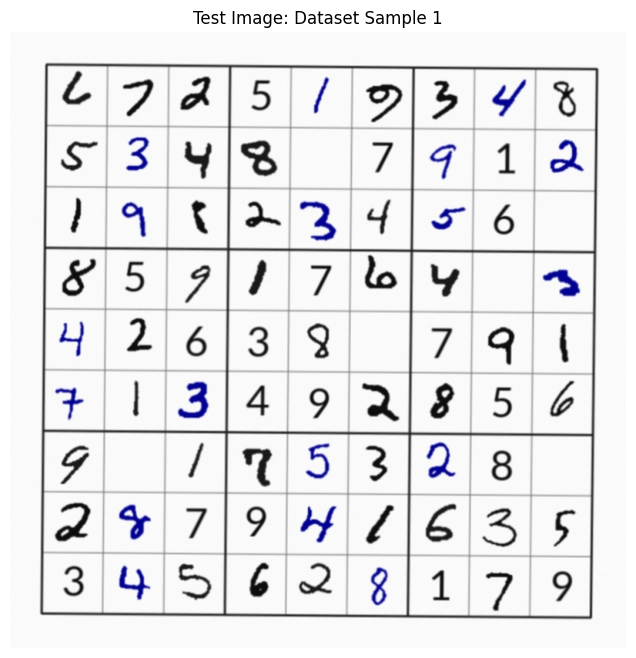


Processing with regular processor...


2025-05-14 17:08:50.379257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-14 17:08:50.474741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


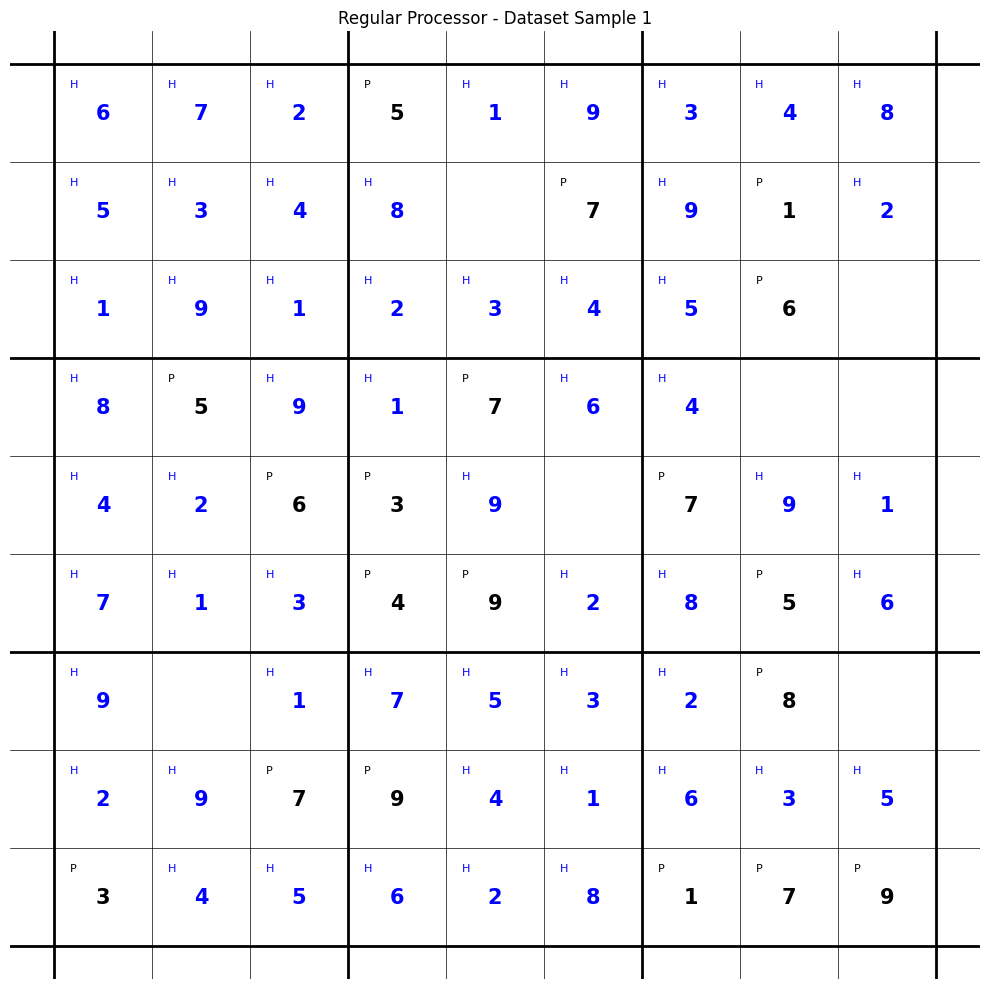

Regular processor stats:
- total_cells: 81
- filled_cells: 74
- empty_cells: 7
- handwritten_cells: 55
- printed_cells: 19
- fill_percentage: 91.36%
- is_valid: False
- mode: mixed
- average_confidence: 99.51%

Board is invalid, regular processor will not attempt solving.

Processing with improved processor...


2025-05-14 17:08:53.588357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-14 17:08:53.669475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


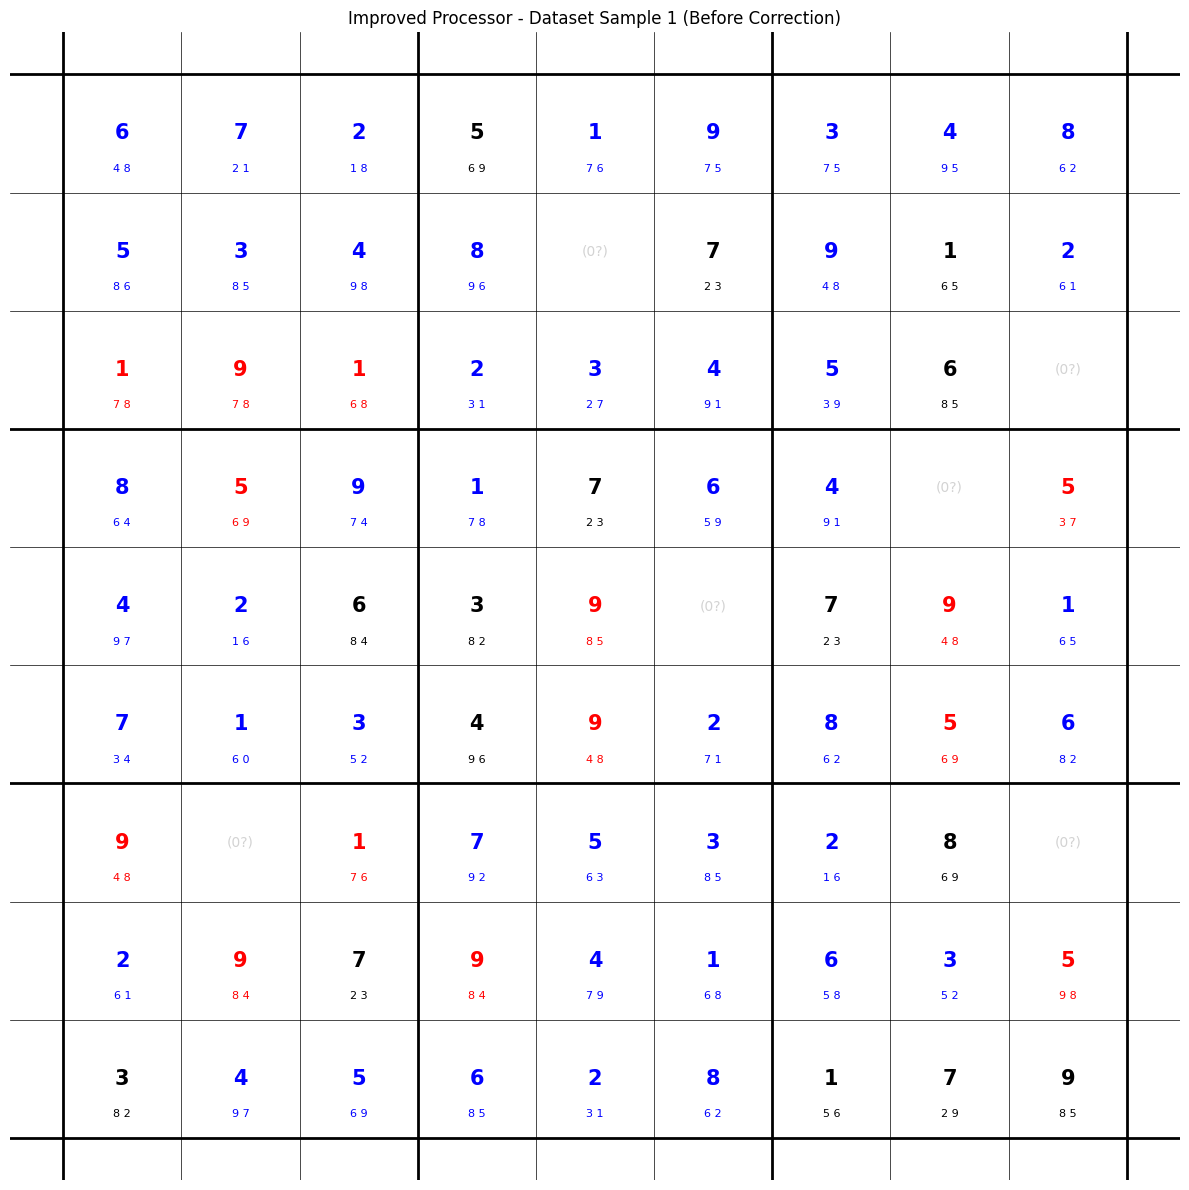

Improved processor stats (before correction):
- total_cells: 81
- filled_cells: 75
- empty_cells: 6
- handwritten_cells: 56
- printed_cells: 19
- fill_percentage: 92.59%
- is_valid: False
- mode: mixed
- average_confidence: 98.84%

Detailed predictions for problematic cells:
Cell Predictions (with alternatives):
Cell(0,0): 6(1.00) [none] 
Cell(0,1): 7(1.00) [none] 
Cell(0,2): 2(1.00) [none] 
Cell(0,3): 5(1.00) [none] 
Cell(0,4): 1(1.00) [none] 
Cell(0,5): 9(1.00) [none] 
Cell(0,6): 3(1.00) [none] 
Cell(0,7): 4(1.00) [none] 
Cell(0,8): 8(1.00) [none] 
Cell(1,0): 5(1.00) [none] 
Cell(1,1): 3(1.00) [none] 
Cell(1,2): 4(1.00) [none] 
Cell(1,3): 8(1.00) [none] 
Cell(1,4): 0(1.00) [none] 
Cell(1,5): 7(1.00) [none] 
Cell(1,6): 9(1.00) [none] 
Cell(1,7): 1(1.00) [none] 
Cell(1,8): 2(1.00) [none] 
Cell(2,0): 1(1.00) [none] PROBLEMATIC
Cell(2,1): 9(1.00) [none] PROBLEMATIC
Cell(2,2): 1(1.00) [none] PROBLEMATIC
Cell(2,3): 2(1.00) [none] 
Cell(2,4): 3(1.00) [none] 
Cell(2,5): 4(1.00) [none] 
Cell(

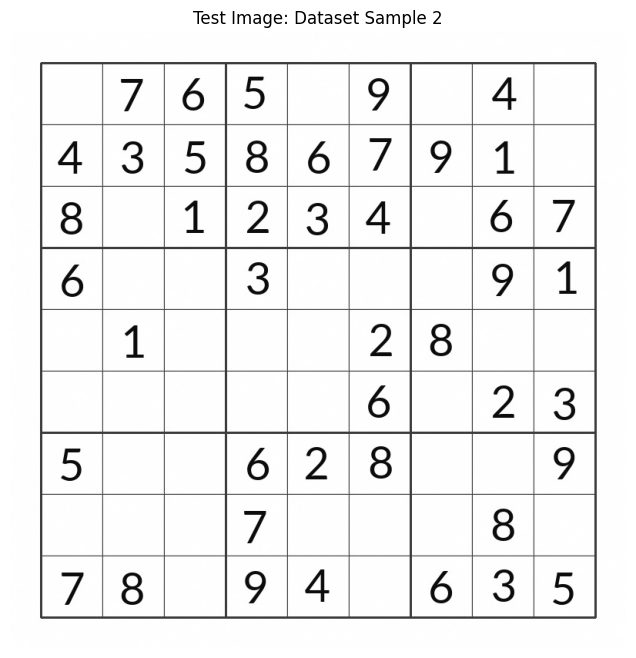


Processing with regular processor...


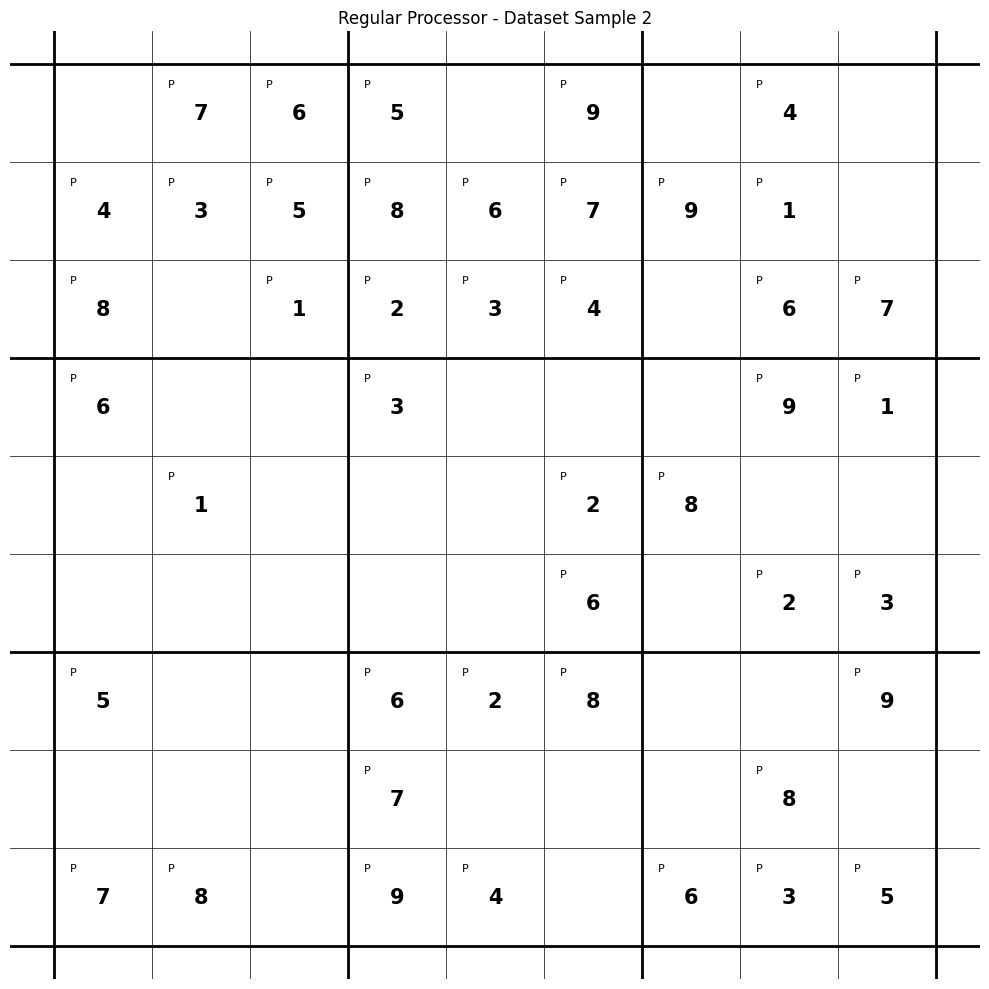

Regular processor stats:
- total_cells: 81
- filled_cells: 44
- empty_cells: 37
- handwritten_cells: 0
- printed_cells: 44
- fill_percentage: 54.32%
- is_valid: True
- mode: printed
- average_confidence: 99.98%

Attempting to solve with regular processor...
Regular processor found a solution!


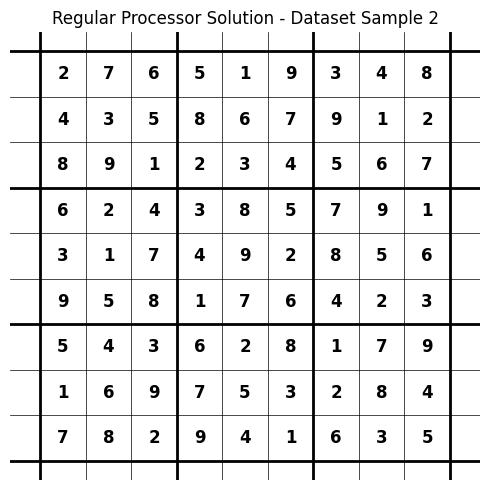


Processing with improved processor...


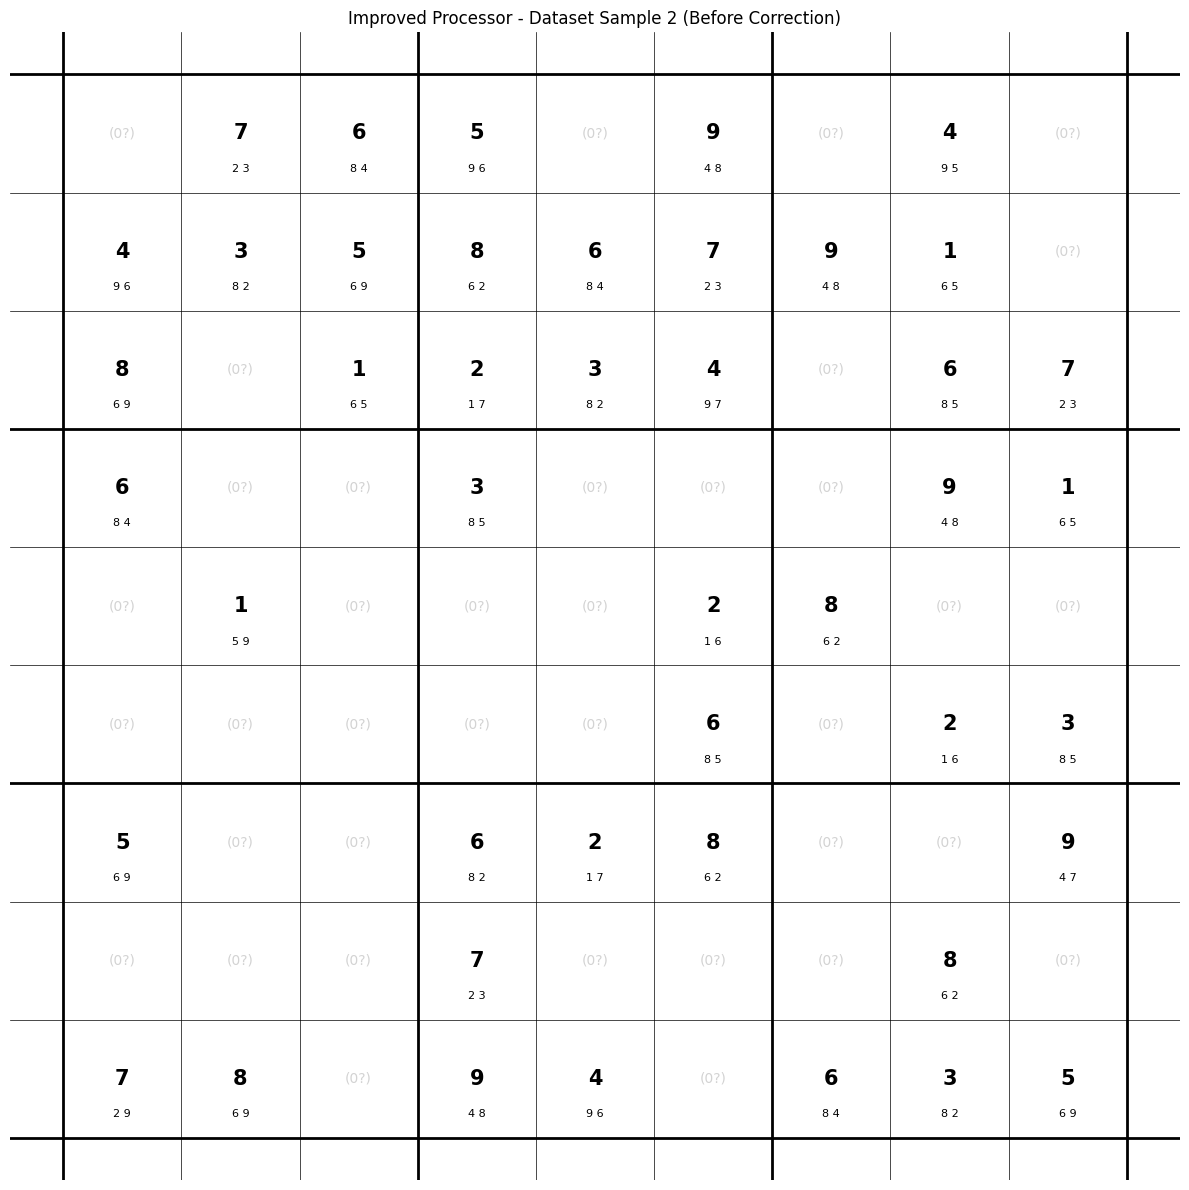

Improved processor stats (before correction):
- total_cells: 81
- filled_cells: 44
- empty_cells: 37
- handwritten_cells: 0
- printed_cells: 44
- fill_percentage: 54.32%
- is_valid: True
- mode: printed
- average_confidence: 99.98%

Board is valid, attempting to solve...
Improved processor found a solution!


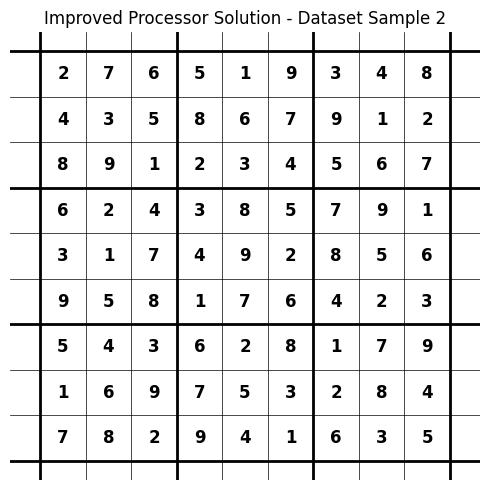


--------------------------------------------------
Processing Dataset Sample 3
--------------------------------------------------


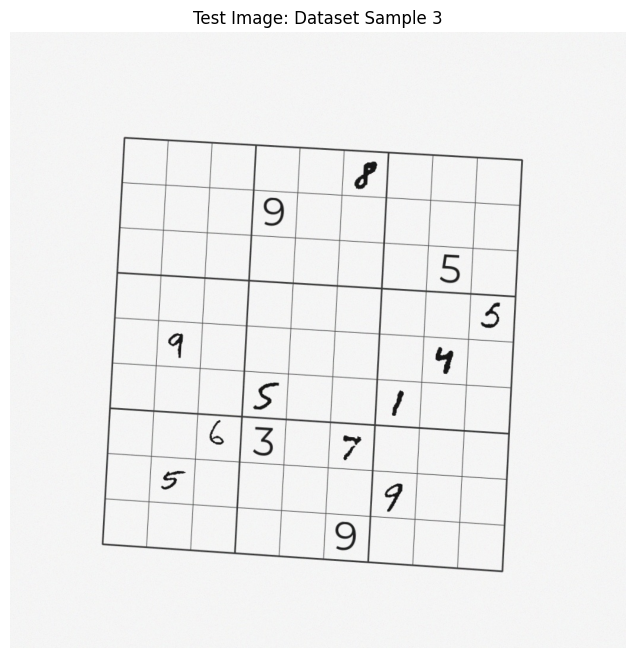


Processing with regular processor...


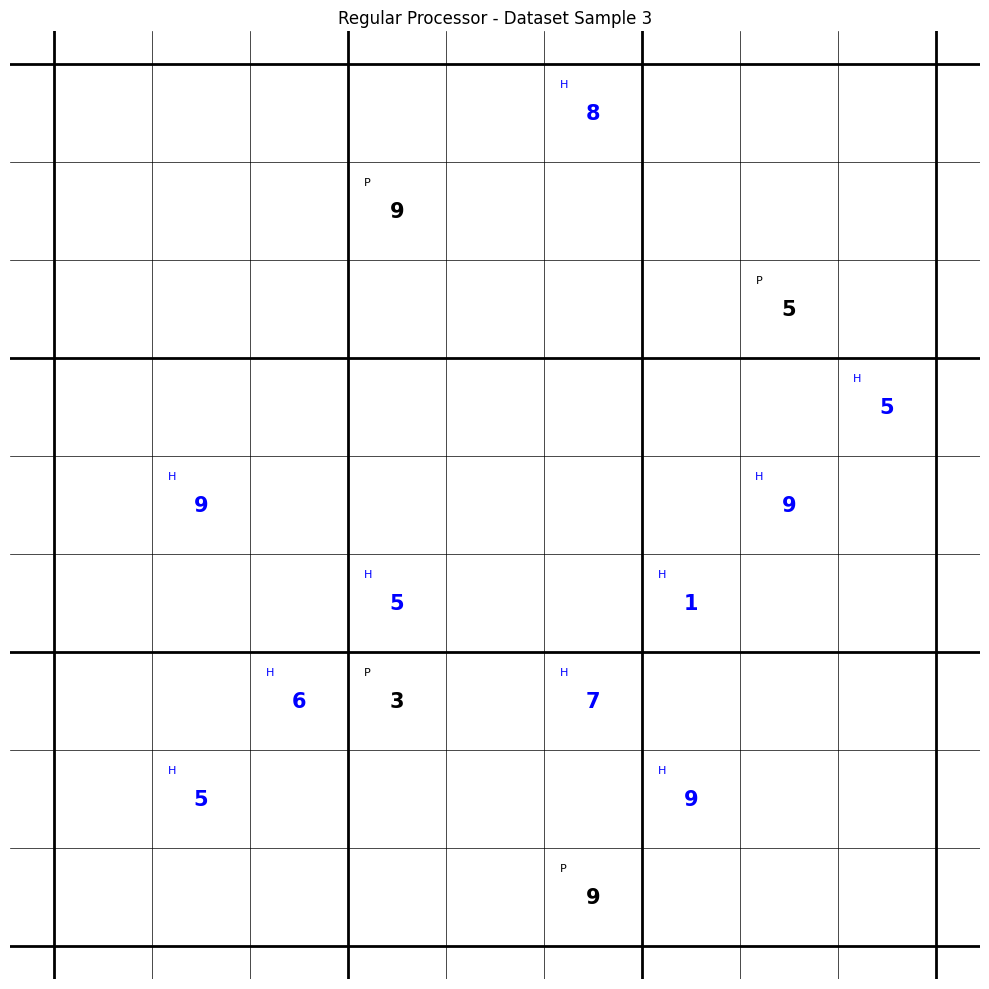

Regular processor stats:
- total_cells: 81
- filled_cells: 14
- empty_cells: 67
- handwritten_cells: 10
- printed_cells: 4
- fill_percentage: 17.28%
- is_valid: False
- mode: mixed
- average_confidence: 96.25%

Board is invalid, regular processor will not attempt solving.

Processing with improved processor...


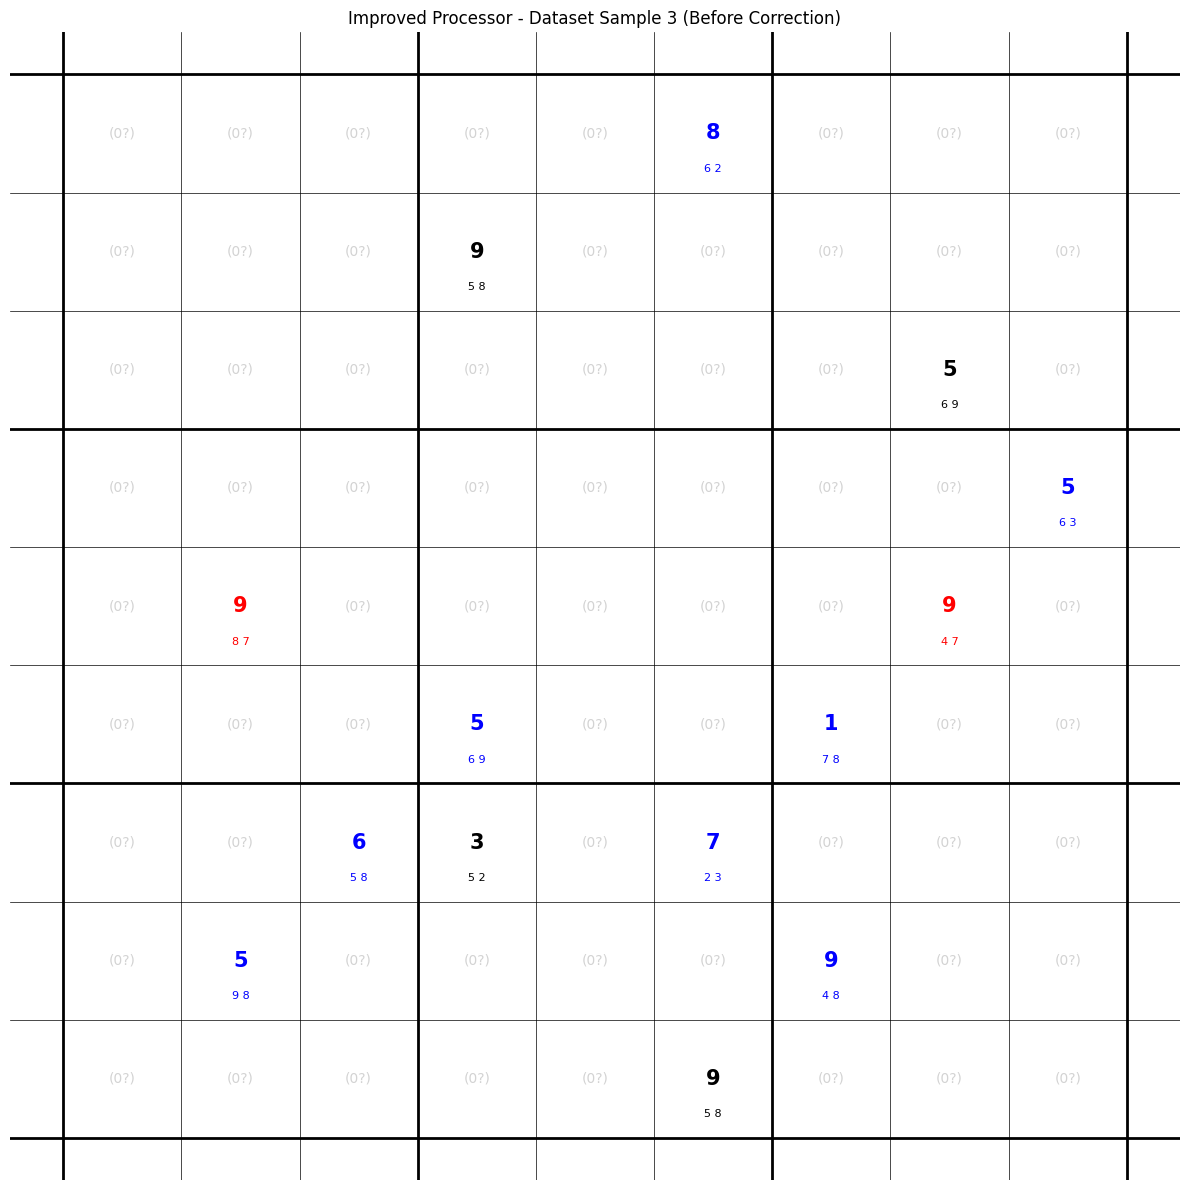

Improved processor stats (before correction):
- total_cells: 81
- filled_cells: 14
- empty_cells: 67
- handwritten_cells: 10
- printed_cells: 4
- fill_percentage: 17.28%
- is_valid: False
- mode: mixed
- average_confidence: 96.25%

Detailed predictions for problematic cells:
Cell Predictions (with alternatives):
Cell(0,0): 0(1.00) [none] 
Cell(0,1): 0(1.00) [none] 
Cell(0,2): 0(1.00) [none] 
Cell(0,3): 0(1.00) [none] 
Cell(0,4): 0(1.00) [none] 
Cell(0,5): 8(1.00) [none] 
Cell(0,6): 0(1.00) [none] 
Cell(0,7): 0(1.00) [none] 
Cell(0,8): 0(1.00) [none] 
Cell(1,0): 0(1.00) [none] 
Cell(1,1): 0(1.00) [none] 
Cell(1,2): 0(1.00) [none] 
Cell(1,3): 9(1.00) [none] 
Cell(1,4): 0(1.00) [none] 
Cell(1,5): 0(1.00) [none] 
Cell(1,6): 0(1.00) [none] 
Cell(1,7): 0(1.00) [none] 
Cell(1,8): 0(1.00) [none] 
Cell(2,0): 0(1.00) [none] 
Cell(2,1): 0(1.00) [none] 
Cell(2,2): 0(1.00) [none] 
Cell(2,3): 0(1.00) [none] 
Cell(2,4): 0(1.00) [none] 
Cell(2,5): 0(1.00) [none] 
Cell(2,6): 0(1.00) [none] 
Cell(2,7): 

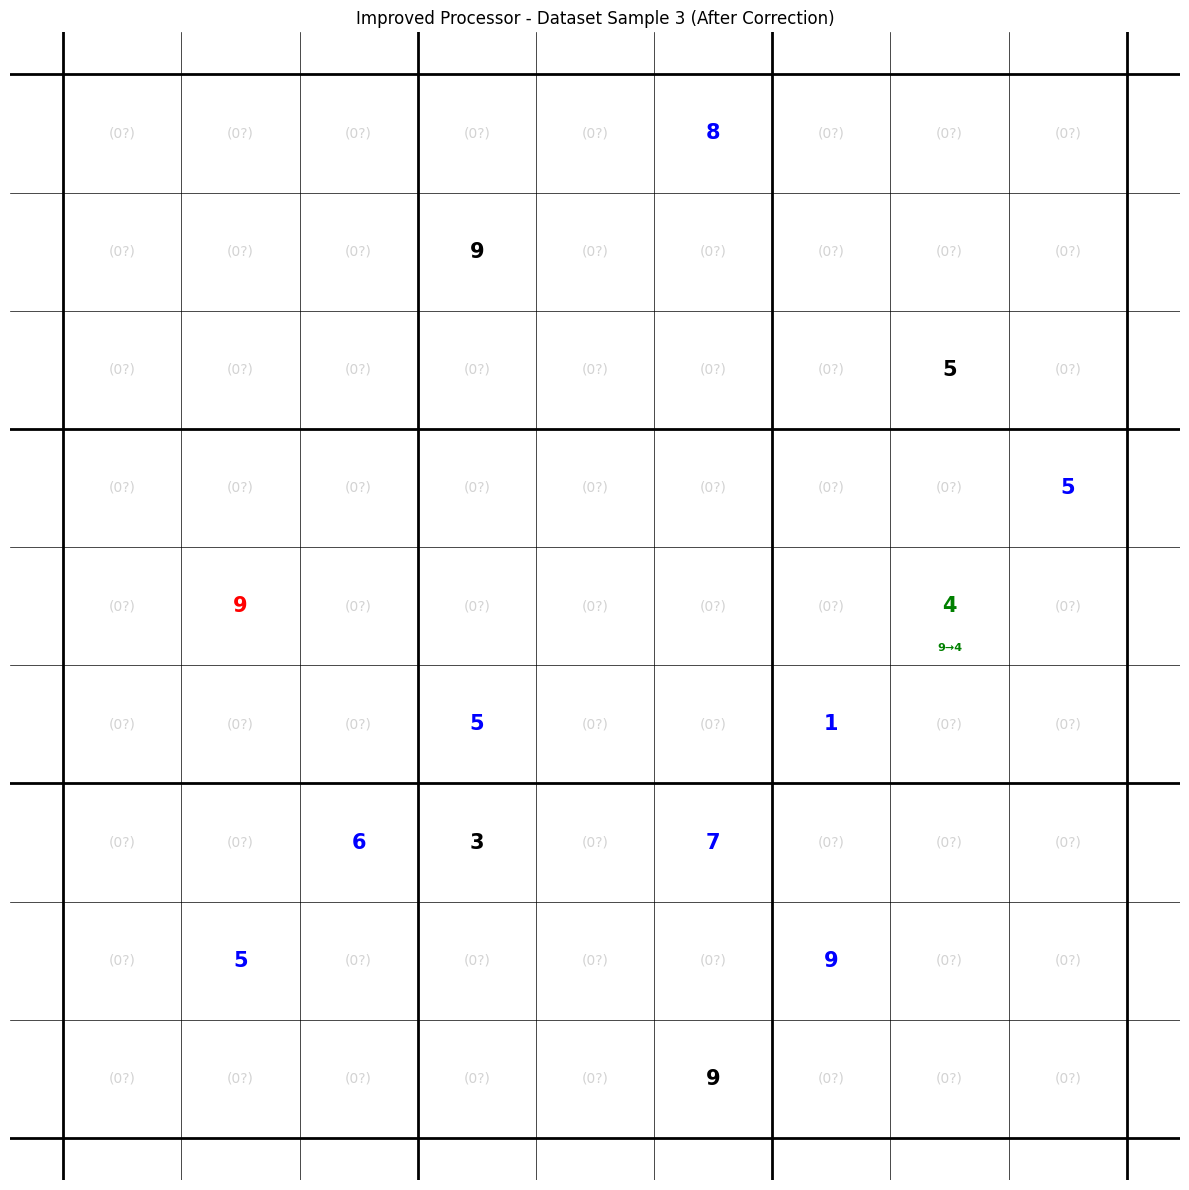


Attempting to solve the corrected board...
Found a solution for the corrected board!


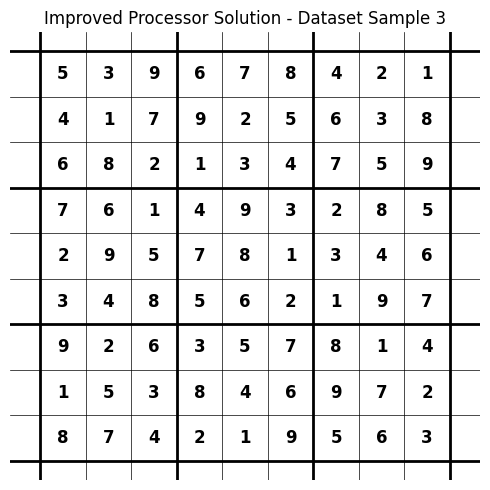

In [8]:
# Process each test image
results = []

for image_path, name in test_image_paths:
    reg_board, imp_board = compare_processors(image_path, name)
    results.append({
        'name': name,
        'path': image_path,
        'reg_board': reg_board,
        'imp_board': imp_board,
        'reg_valid': reg_board.is_valid if reg_board else False,
        'imp_valid': imp_board.is_valid if imp_board else False,
        'reg_solved': hasattr(reg_board, 'solution') and reg_board.solution is not None if reg_board else False,
        'imp_solved': hasattr(imp_board, 'solution') and imp_board.solution is not None if imp_board else False
    })

## Manual Cell Override

If auto-correction doesn't work, we can manually override problematic cells.

In [9]:
def manually_correct_board(board):
    """Manually correct problematic cells in a board."""
    if not isinstance(board, ImprovedSudokuBoard):
        print("This function only works with ImprovedSudokuBoard objects.")
        return board
    
    # Make sure problematic cells are identified
    if not board.problematic_cells:
        board.validate_with_improvements()
    
    if not board.problematic_cells:
        print("No problematic cells identified.")
        return board
    
    print(f"Found {len(board.problematic_cells)} problematic cells:")
    for i, (row, col) in enumerate(board.problematic_cells):
        cell_pred = board.cell_predictions[row, col]
        if cell_pred:
            print(f"{i+1}. {cell_pred}")
    
    # Display the board with alternatives
    board.display_with_alternatives(title="Board with Problematic Cells")
    
    # Ask for manual corrections
    print("\nEnter manual corrections in the format 'row,col,value' (e.g., '2,3,5')")
    print("Enter multiple corrections separated by semicolons (e.g., '2,3,5; 4,5,9')")
    print("Enter 'done' when finished")
    
    while True:
        user_input = input("\nCorrections (or 'done'): ")
        if user_input.lower() == 'done':
            break
        
        # Parse the corrections
        corrections = [c.strip() for c in user_input.split(';')]
        for correction in corrections:
            try:
                parts = correction.split(',')
                if len(parts) != 3:
                    print(f"Invalid format for correction: {correction}")
                    continue
                
                row = int(parts[0])
                col = int(parts[1])
                value = int(parts[2])
                
                if row < 0 or row > 8 or col < 0 or col > 8 or value < 0 or value > 9:
                    print(f"Invalid values in correction: {correction}")
                    continue
                
                # Apply the correction
                print(f"Applying correction: ({row},{col}) = {value}")
                board.apply_correction(row, col, value)
                
            except ValueError:
                print(f"Invalid format for correction: {correction}")
        
        # Re-validate the board
        is_valid = board.validate_with_improvements()
        print(f"Board is now {'valid' if is_valid else 'invalid'}")
        
        # Display the updated board
        board.display_with_alternatives(title="Board After Corrections")
        
        if is_valid:
            print("Board is now valid! No more corrections needed.")
            break
        else:
            print(f"Still have {len(board.problematic_cells)} problematic cells:")
            for i, (row, col) in enumerate(board.problematic_cells):
                cell_pred = board.cell_predictions[row, col]
                if cell_pred:
                    print(f"{i+1}. {cell_pred}")
    
    return board

Found an invalid board from Dataset Sample 1 that needs manual correction:
Found 14 problematic cells:
1. Cell(2,0): 1(1.00) [7(0.00), 8(0.00)] PROBLEMATIC
2. Cell(2,2): 1(1.00) [6(0.00), 8(0.00)] PROBLEMATIC
3. Cell(3,1): 5(1.00) [6(0.00), 9(0.00)] PROBLEMATIC
4. Cell(3,8): 5(0.49) [3(0.25), 7(0.11)] PROBLEMATIC
5. Cell(4,4): 9(0.88) [8(0.12), 5(0.00)] PROBLEMATIC
6. Cell(4,7): 9(1.00) [4(0.00), 8(0.00)] PROBLEMATIC
7. Cell(7,1): 9(0.89) [8(0.07), 4(0.03)] PROBLEMATIC
8. Cell(7,3): 9(1.00) [8(0.00), 4(0.00)] PROBLEMATIC
9. Cell(2,1): 9(1.00) [7(0.00), 8(0.00)] PROBLEMATIC
10. Cell(6,2): 1(1.00) [7(0.00), 6(0.00)] PROBLEMATIC
11. Cell(5,4): 9(1.00) [4(0.00), 8(0.00)] PROBLEMATIC
12. Cell(7,8): 5(1.00) [9(0.00), 8(0.00)] PROBLEMATIC
13. Cell(5,7): 5(1.00) [6(0.00), 9(0.00)] PROBLEMATIC
14. Cell(6,0): 9(1.00) [4(0.00), 8(0.00)] PROBLEMATIC


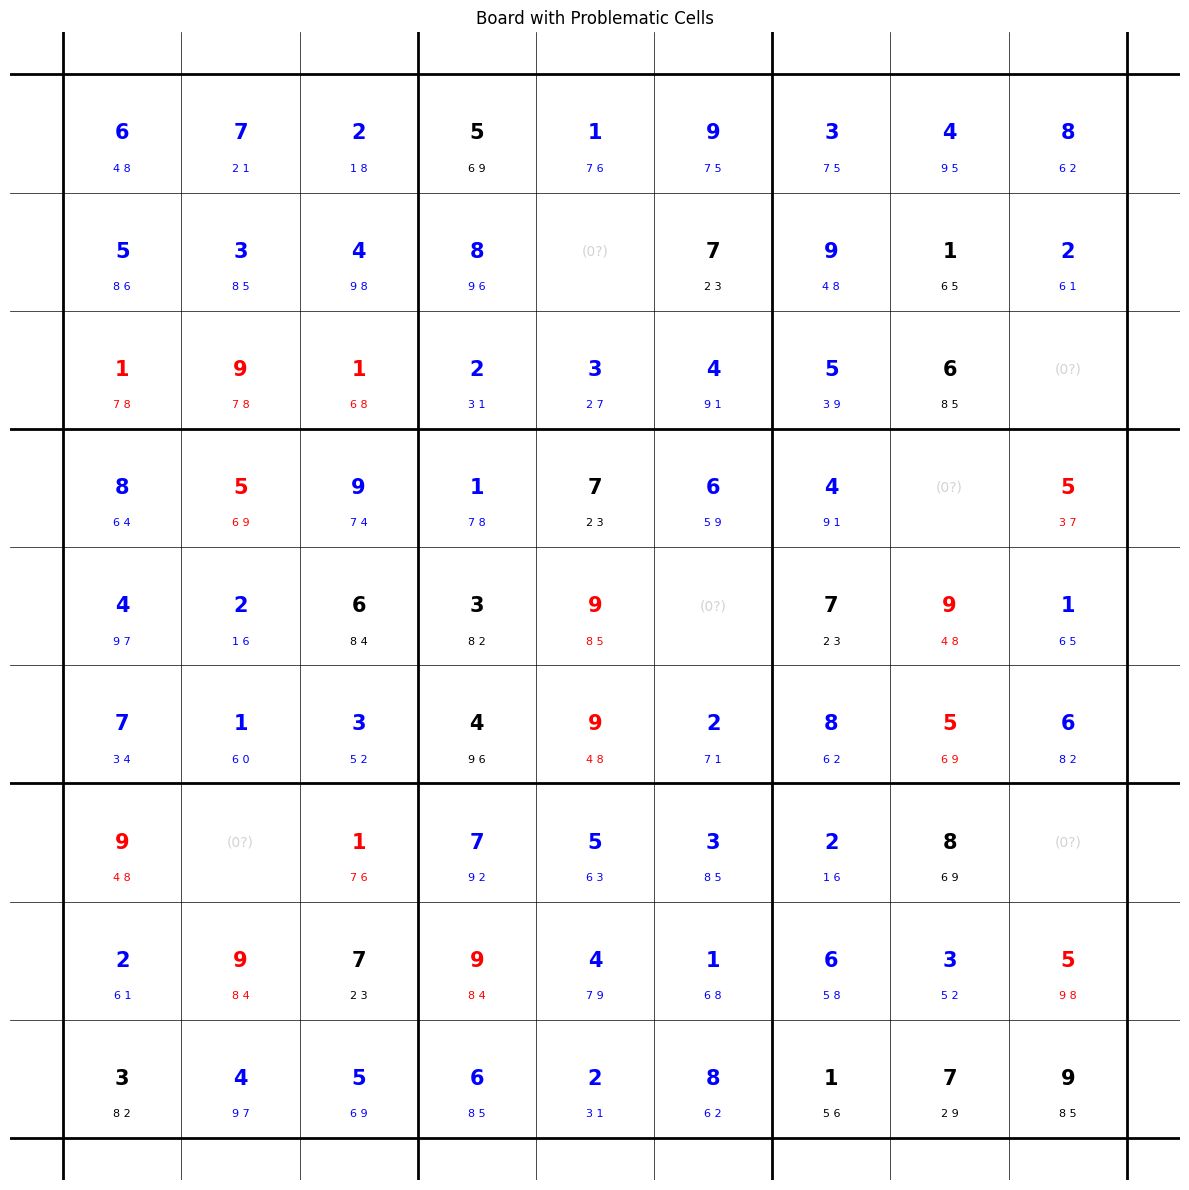


Enter manual corrections in the format 'row,col,value' (e.g., '2,3,5')
Enter multiple corrections separated by semicolons (e.g., '2,3,5; 4,5,9')
Enter 'done' when finished


In [ ]:
# Find an invalid board that couldn't be auto-corrected
for result in results:
    if not result['imp_valid'] and result['imp_board'] is not None:
        print(f"Found an invalid board from {result['name']} that needs manual correction:")
        
        # Get a fresh copy of the board (without prior auto-correction)
        board = improved_processor.process_image(result['path'], display_steps=False, auto_correct=False)
        
        if board:
            # Try manual correction
            corrected_board = manually_correct_board(board)
            
            # Attempt to solve the corrected board
            if corrected_board.is_valid:
                print("\nAttempting to solve the manually corrected board...")
                solution_found = improved_processor.solve_board(corrected_board)
                if solution_found:
                    print("Found a solution for the manually corrected board!")
                    plot_grid(corrected_board.solution, title=f"Solution After Manual Correction - {result['name']}")
                else:
                    print("Could not find a solution for the manually corrected board.")
            else:
                print("Board is still invalid after manual corrections.")
            
            break
else:
    print("No invalid boards found to demonstrate manual correction.")
    print("Try processing a more challenging image that produces an invalid board.")

## Improvements Summary

The improved Sudoku processor offers several key advantages over the basic version:

In [ ]:
# Print a summary of the results
print("SUMMARY OF RESULTS:\n")
print(f"{'-'*80}")
print(f"{'Image Name':<20} | {'Regular Valid':<15} | {'Improved Valid':<15} | {'Regular Solved':<15} | {'Improved Solved':<15}")
print(f"{'-'*80}")

for result in results:
    name = result['name']
    reg_valid = "Valid" if result['reg_valid'] else "Invalid"
    imp_valid = "Valid" if result['imp_valid'] else "Invalid"
    reg_solved = "Solved" if result['reg_solved'] else "Not Solved"
    imp_solved = "Solved" if result['imp_solved'] else "Not Solved"
    
    print(f"{name:<20} | {reg_valid:<15} | {imp_valid:<15} | {reg_solved:<15} | {imp_solved:<15}")

print(f"{'-'*80}")

## Key Improvements

The improved Sudoku processor offers several advantages over the basic version:

1. **Multiple Predictions**: Stores the top-N predictions for each cell instead of only the best guess

2. **Conflict Detection**: Identifies specific cells causing validation failures

3. **Auto-Correction**: Automatically tries alternative predictions to fix invalid boards

4. **Manual Override**: Provides a user interface for manually correcting problematic cells

5. **Detailed Visualization**: Shows alternative predictions and problematic cells clearly

These improvements significantly increase the robustness of the Sudoku processing pipeline, making it much more likely to successfully handle challenging puzzles with uncertain digit recognition.

## Process Your Own Image

You can also process your own custom Sudoku image with the improved processor.

In [9]:
def process_custom_image_improved(image_path):
    """Process a custom Sudoku image with the improved processor."""
    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
        
    # Display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Custom Image")
    plt.axis('off')
    plt.show()
    
    # Process with improved processor
    print("\nProcessing with improved processor...")
    board = improved_processor.process_image(image_path, display_steps=True, auto_correct=True)
    
    if board:
        # Display the extracted board with alternatives
        board.display_with_alternatives(title="Extracted Custom Board")
        
        # Print board stats
        print("Board Statistics:")
        stats = board.get_stats()
        for key, value in stats.items():
            print(f"- {key}: {value}")
        
        # Print cell predictions
        improved_processor.print_cell_predictions(board, min_confidence=0.2)
        
        if not board.is_valid:
            # Try manual correction if auto-correction didn't work
            print("\nBoard is invalid. Would you like to manually correct it? (y/n)")
            user_input = input()
            if user_input.lower() == 'y':
                board = manually_correct_board(board)
        
        # Try to solve the board if it's valid
        if board.is_valid:
            print("\nAttempting to solve the board...")
            solution_found = improved_processor.solve_board(board)
            if solution_found:
                print("Solution found!")
                plot_grid(board.solution, title="Solved Custom Puzzle")
            else:
                print("Could not find a solution.")
        else:
            print("\nBoard is still invalid. Cannot attempt to solve.")
    else:
        print("Failed to process the image.")
        
    return board

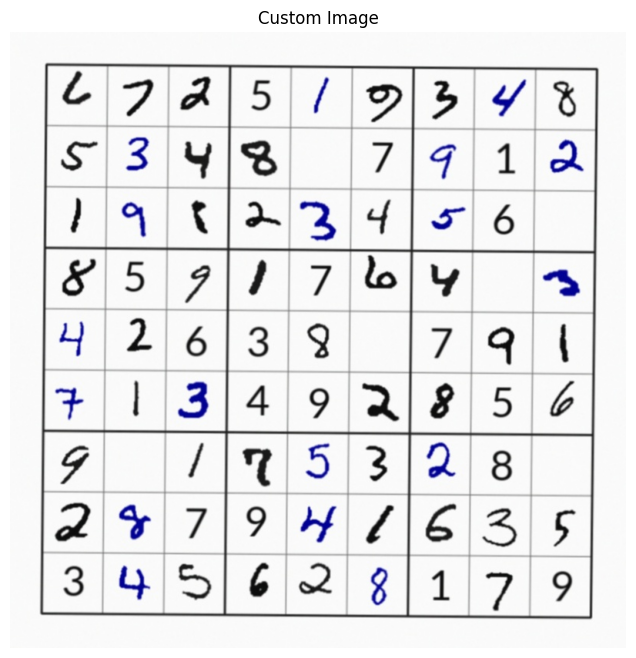


Processing with improved processor...


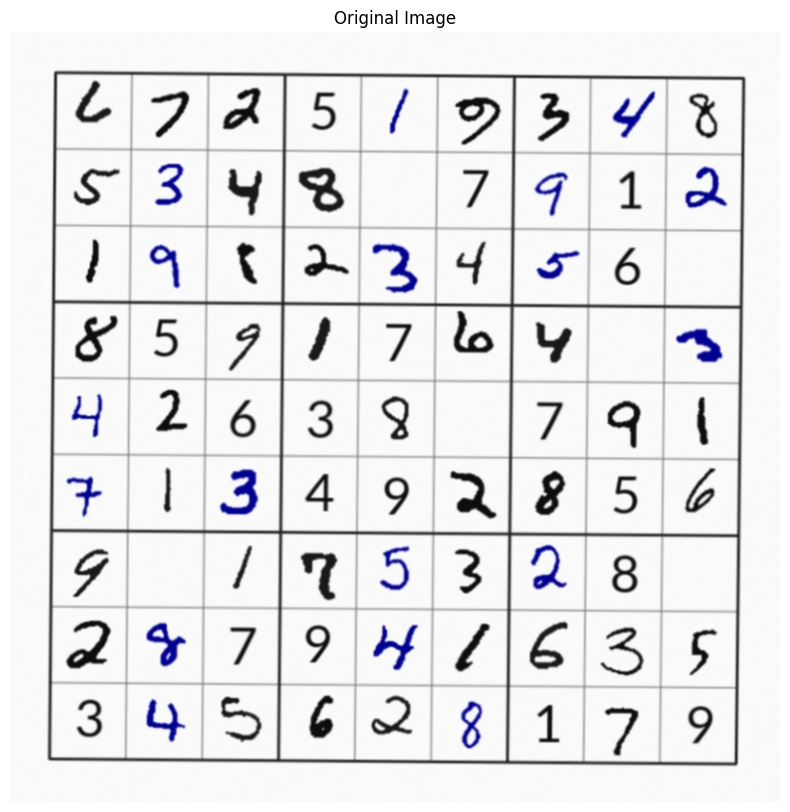

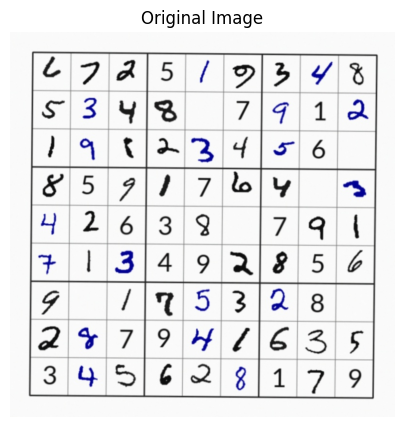

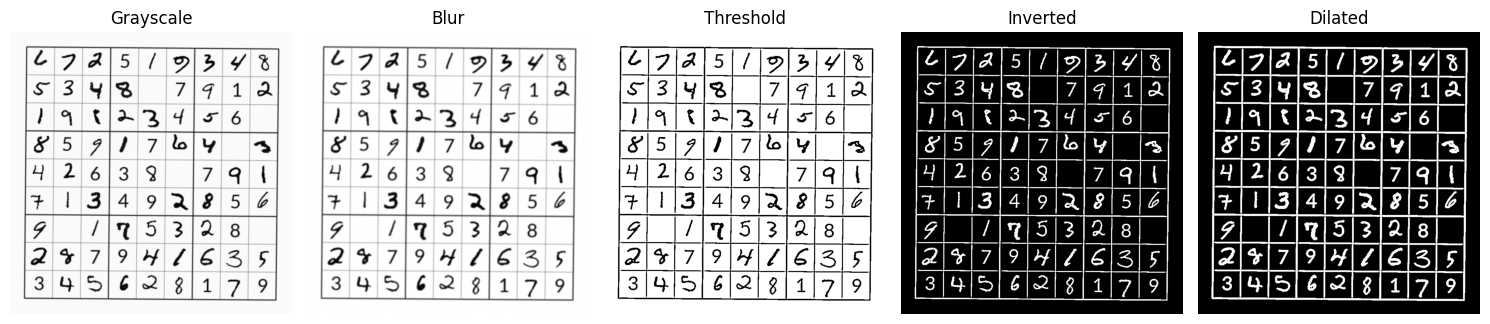

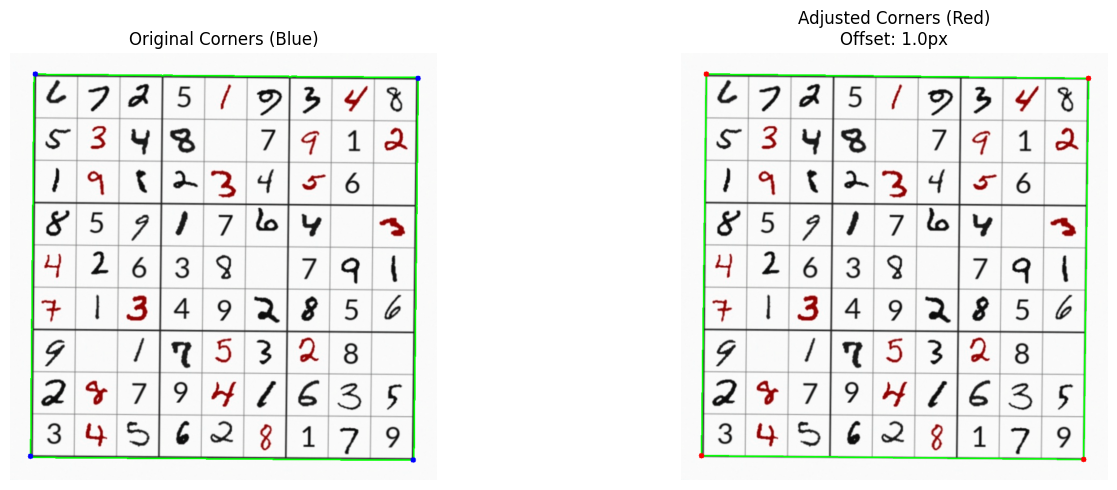

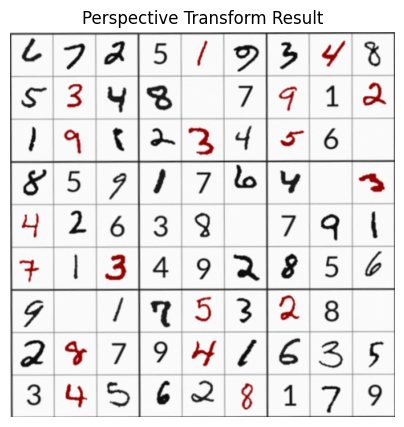

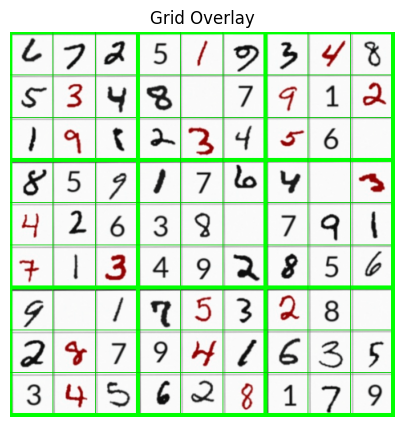

Board is invalid. Attempting automatic correction...
Successfully corrected the board!


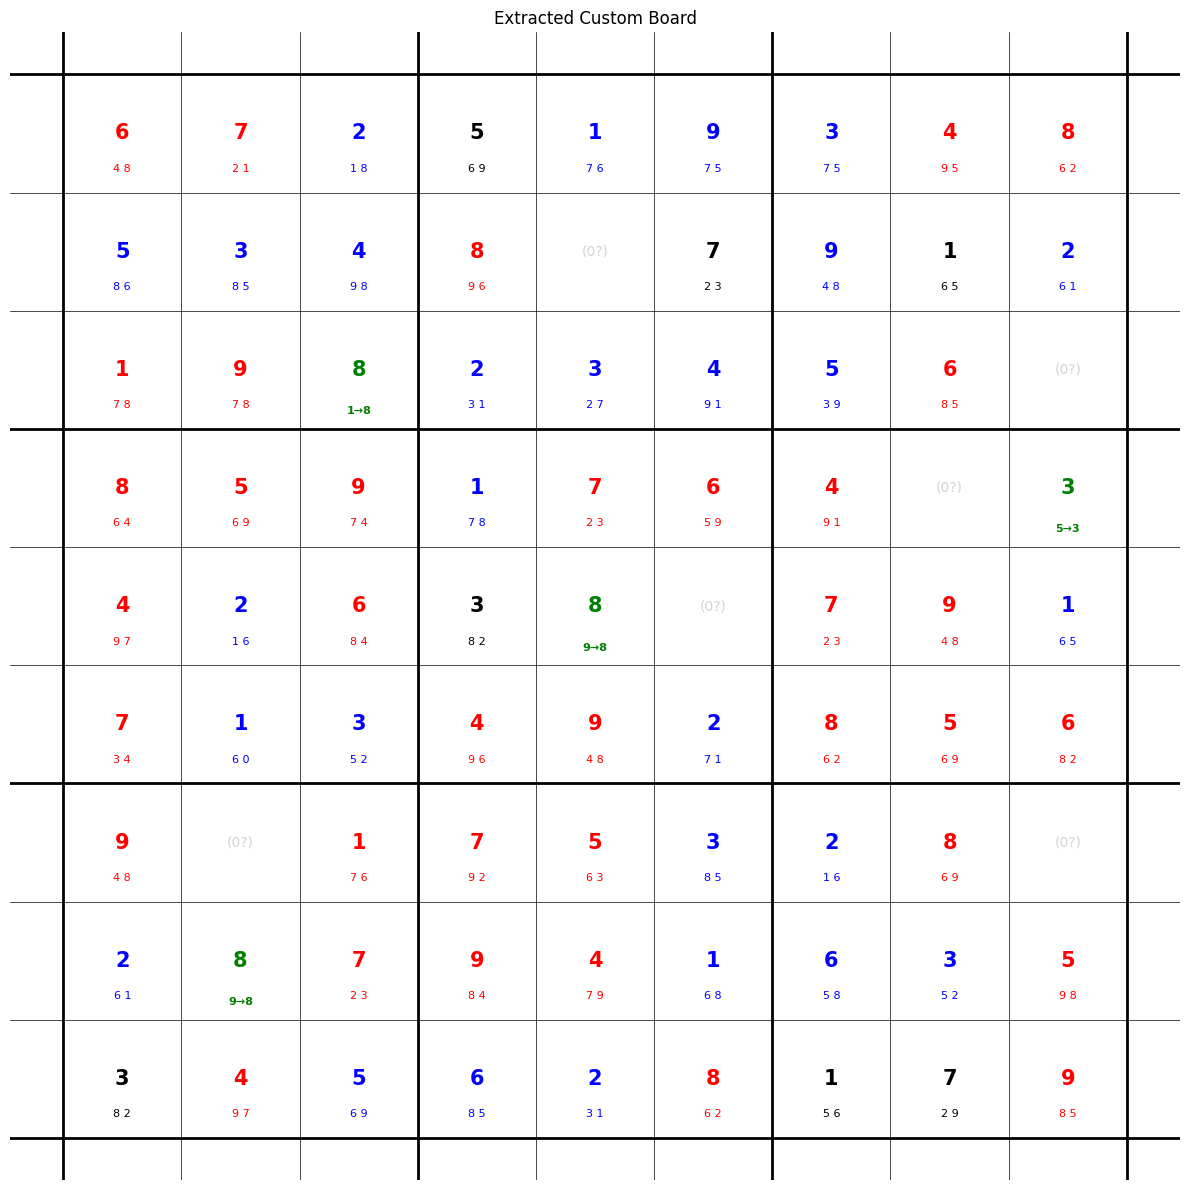

Board Statistics:
- total_cells: 81
- filled_cells: 75
- empty_cells: 6
- handwritten_cells: 56
- printed_cells: 19
- fill_percentage: 92.59%
- is_valid: True
- mode: mixed
- average_confidence: 98.84%
Cell Predictions (with alternatives):
Cell(0,0): 6(1.00) [none] PROBLEMATIC
Cell(0,1): 7(1.00) [none] PROBLEMATIC
Cell(0,2): 2(1.00) [none] 
Cell(0,3): 5(1.00) [none] 
Cell(0,4): 1(1.00) [none] 
Cell(0,5): 9(1.00) [none] 
Cell(0,6): 3(1.00) [none] 
Cell(0,7): 4(1.00) [none] PROBLEMATIC
Cell(0,8): 8(1.00) [none] PROBLEMATIC
Cell(1,0): 5(1.00) [none] 
Cell(1,1): 3(1.00) [none] 
Cell(1,2): 4(1.00) [none] 
Cell(1,3): 8(1.00) [none] PROBLEMATIC
Cell(1,4): 0(1.00) [none] 
Cell(1,5): 7(1.00) [none] 
Cell(1,6): 9(1.00) [none] 
Cell(1,7): 1(1.00) [none] 
Cell(1,8): 2(1.00) [none] 
Cell(2,0): 1(1.00) [none] PROBLEMATIC
Cell(2,1): 9(1.00) [none] PROBLEMATIC
Cell(2,2): 1(1.00) [none] PROBLEMATIC → 8
Cell(2,3): 2(1.00) [none] 
Cell(2,4): 3(1.00) [none] 
Cell(2,5): 4(1.00) [none] 
Cell(2,6): 5(0.99) [

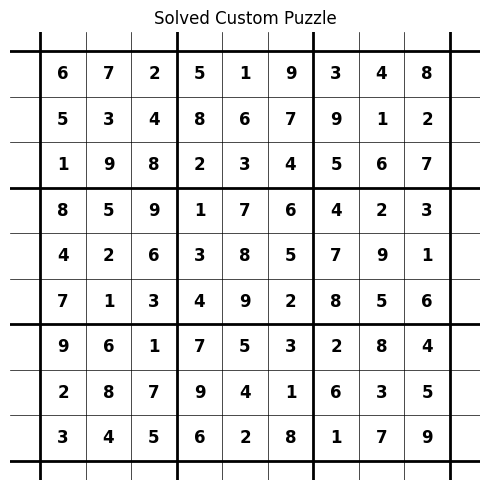

In [10]:
# Example usage with a custom image
# Replace with your own image path
custom_image_path = "../data/temp_test_image.jpg"
custom_board = process_custom_image_improved(custom_image_path)

## Conclusion

The improved Sudoku processing system significantly enhances the robustness of the pipeline by:

1. Storing multiple predictions for each cell instead of just the top prediction
2. Identifying specific cells that cause validation issues
3. Automatically trying alternative predictions to correct problematic cells
4. Providing a clear interface for manual correction when needed

This approach makes the system much more capable of handling challenging real-world Sudoku images where digit recognition might be uncertain. The key innovation is tracking alternative predictions and using them to fix validation issues, either automatically or with user assistance.